Successfully loaded data with 16 records
First few rows:
   Unnamed: 0  Case  Stratum  Cluster  Variable
0         NaN     1        1        1      11.5
1         NaN     2        1        1      29.0
2         NaN     3        1        2      35.6
3         NaN     4        1        2      64.7
4         NaN     5        2        3      19.2

==== Simple Random Sampling Analysis ====
1) Mean (SRS): 50.60
2) Standard Error (SRS): 6.8851
3) 95% Confidence Interval (SRS):
   Upper limit: 64.6455
   Lower limit: 36.5545

==== Clustered Random Sampling Analysis ====
1) Mean (Clustered): 50.60
2) Standard Error (Clustered): 7.6243
3) Design Effect (d-value): 1.1074
4) d-squared: 1.2263
5) Intraclass correlation (roh): 0.2263
6) Effective sample size (Neff): 13.0477

==== Summary of Results (Rounded as Required) ====
srs_mean: 50.6
srs_se: 6.8851
ci_upper: 64.6455
ci_lower: 36.5545
crs_mean: 50.6
crs_se: 7.6243
d_value: 1.1074
d_squared: 1.2263
roh: 0.2263
Neff: 13.0477


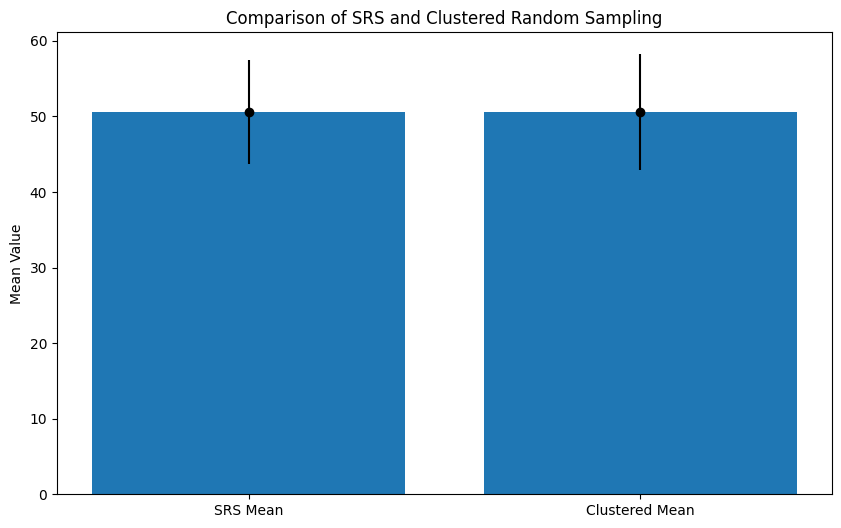

In [ ]:
#1 task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any


def load_data(file_path: str) -> pd.DataFrame:
    try:
        data = pd.read_excel(file_path, engine='openpyxl')
        print(f"Successfully loaded data with {len(data)} records")
        print("First few rows:")
        print(data.head())
        return data
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return pd.DataFrame()


def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
    required_columns = ['Case', 'Stratum', 'Cluster', 'Variable']
    for column in required_columns:
        if column not in data.columns:
            print(f"Error: '{column}' column not found in the dataset.")
            return pd.DataFrame()

    data['response'] = data['Variable']
    data['cluster_id'] = data['Cluster']
    return data


def simple_random_sampling(data: pd.DataFrame) -> Dict[str, float]:
    print("\n==== Simple Random Sampling Analysis ====")
    srs_mean = data['response'].mean()
    print(f"1) Mean (SRS): {srs_mean:.2f}")

    n = len(data)
    srs_std = data['response'].std(ddof=1)
    srs_se = srs_std / np.sqrt(n)
    print(f"2) Standard Error (SRS): {srs_se:.4f}")

    t_value = 2.04
    margin_of_error = t_value * srs_se
    ci_upper = srs_mean + margin_of_error
    ci_lower = srs_mean - margin_of_error
    print(f"3) 95% Confidence Interval (SRS):")
    print(f"   Upper limit: {ci_upper:.4f}")
    print(f"   Lower limit: {ci_lower:.4f}")

    return {
        'srs_mean': srs_mean,
        'srs_se': srs_se,
        'ci_upper': ci_upper,
        'ci_lower': ci_lower
    }


def clustered_random_sampling(data: pd.DataFrame, srs_se: float) -> Dict[str, float]:
    print("\n==== Clustered Random Sampling Analysis ====")
    cluster_means = data.groupby('cluster_id')['response'].mean()
    crs_mean = cluster_means.mean()
    print(f"1) Mean (Clustered): {crs_mean:.2f}")

    M = len(cluster_means)
    cluster_var = np.var(cluster_means, ddof=1)
    crs_se = np.sqrt(cluster_var / M)
    print(f"2) Standard Error (Clustered): {crs_se:.4f}")

    d_value = crs_se / srs_se
    print(f"3) Design Effect (d-value): {d_value:.4f}")

    d_squared = d_value ** 2
    print(f"4) d-squared: {d_squared:.4f}")

    n_avg = data.groupby('cluster_id').size().mean()
    roh = (d_squared - 1) / (n_avg - 1) if n_avg > 1 else 0
    print(f"5) Intraclass correlation (roh): {roh:.4f}")

    Neff = len(data) / d_squared
    print(f"6) Effective sample size (Neff): {Neff:.4f}")

    return {
        'crs_mean': crs_mean,
        'crs_se': crs_se,
        'd_value': d_value,
        'd_squared': d_squared,
        'roh': roh,
        'Neff': Neff
    }


def plot_comparison(srs_mean: float, crs_mean: float, srs_se: float, crs_se: float):
    plt.figure(figsize=(10, 6))
    plt.bar(['SRS Mean', 'Clustered Mean'], [srs_mean, crs_mean])
    plt.errorbar(['SRS Mean', 'Clustered Mean'], [srs_mean, crs_mean],
                 yerr=[srs_se, crs_se], fmt='o', color='black')
    plt.title('Comparison of SRS and Clustered Random Sampling')
    plt.ylabel('Mean Value')
    plt.savefig('sampling_comparison.png')


def analyze_survey_data(excel_file_path: str) -> Dict[str, Any]:
    data = load_data(excel_file_path)
    if data.empty:
        return {}

    data = prepare_data(data)
    if data.empty:
        return {}

    srs_results = simple_random_sampling(data)
    crs_results = clustered_random_sampling(data, srs_results['srs_se'])

    plot_comparison(srs_results['srs_mean'], crs_results['crs_mean'],
                    srs_results['srs_se'], crs_results['crs_se'])

    results = {**srs_results, **crs_results}
    return {k: round(v, 4) for k, v in results.items()}


if __name__ == "__main__":
    results = analyze_survey_data('Question1_Final_CP.xlsx')
    if results:
        print("\n==== Summary of Results (Rounded as Required) ====")
        for key, value in results.items():
            print(f"{key}: {value}")

In [ ]:
#2 task

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Read the dataset from CSV file (use the filename as is, since it's in the same directory)
data = pd.read_csv('Question2_Dataset.csv')

# Prepare the features (X) and target (y)
X = data[['X1', 'X2', 'X1^2', 'X1^3', 'X2^2', 'X2^3', 'X1*X2', 'X1^2*X2']].values
y = data['Y'].values.reshape(-1, 1)

# Normalize the features (Z-score normalization)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_normalized, y)

# Get the initial theta parameters (including bias)
initial_theta = np.zeros(X.shape[1] + 1)  # +1 for bias term (9 parameters total: 1 bias + 8 features)
theta = np.concatenate([model.intercept_, model.coef_.flatten()])

# Learning rate
learning_rate = 0.1


# Function to calculate cost (Mean Squared Error)
def calculate_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta[1:]) + theta[0]  # Shape: (m,)
    cost = (1 / (2 * m)) * np.sum((predictions - y.flatten()) ** 2)
    return cost


# Gradient descent implementation
def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)  # Number of samples
    n = X.shape[1]  # Number of features
    cost_history = []

    # Ensure y is flattened to avoid shape mismatch
    y = y.flatten()  # Now y has shape (m,)

    for _ in range(iterations):
        # Calculate predictions (shape: (m,))
        predictions = X.dot(theta[1:]) + theta[0]  # theta[1:] has shape (n,), X has shape (m,n)
        errors = predictions - y  # Shape: (m,)

        # Update bias (theta[0]) - sum over all examples
        theta[0] = theta[0] - (learning_rate / m) * np.sum(errors)

        # Update feature coefficients (theta[1:]) - calculate gradient correctly
        gradient_features = (1 / m) * X.T.dot(errors)  # Shape: (n,) where n=8
        theta[1:] = theta[1:] - learning_rate * gradient_features  # Both shapes (n,)

        cost = calculate_cost(X, y, theta)
        cost_history.append(cost)

    return theta, cost_history


# Run gradient descent for different iterations
n_10_results = gradient_descent(X_normalized, y, initial_theta.copy(), learning_rate, 10)
n_100_results = gradient_descent(X_normalized, y, initial_theta.copy(), learning_rate, 100)
n_1000_results = gradient_descent(X_normalized, y, initial_theta.copy(), learning_rate, 1000)

# Print results in the required format (rounded to integers)
print("n=10")
print("Cost Function (Round):", round(calculate_cost(X_normalized, y, n_10_results[0])))
print("Optimal Theta parameter (Round):", [round(x) for x in n_10_results[0]])

print("\nn=100")
print("Cost Function (Round):", round(calculate_cost(X_normalized, y, n_100_results[0])))
print("Optimal Theta parameter (Round):", [round(x) for x in n_100_results[0]])

print("\nn=1000")
print("Cost Function (Round):", round(calculate_cost(X_normalized, y, n_1000_results[0])))
print("Optimal Theta parameter (Round):", [round(x) for x in n_1000_results[0]])


n=10
Cost Function (Round): 895241
Optimal Theta parameter (Round): [2167, -54, 839, -47, -31, 1001, 1080, 436, 283]

n=100
Cost Function (Round): 42271
Optimal Theta parameter (Round): [3328, 50, 230, 125, 192, 1244, 1897, 18, 63]

n=1000
Cost Function (Round): 1261
Optimal Theta parameter (Round): [3328, -17, -520, 119, 228, 1231, 2651, -64, 200]


In [ ]:
#3 task
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the dataset from CSV file
data = pd.read_csv('Question3_Final_CP.csv')

# Prepare the features (X) and target (y)
X = data[['X1', 'X2', 'X3']].values  # 3 input features
y = data['Y'].values.reshape(-1, 1)  # Binary output (0 or 1)

# Normalize the features (Z-score normalization: Z = (X - mu)/std)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Add intercept term (bias) to X
X_normalized = np.c_[np.ones(X_normalized.shape[0]), X_normalized]  # Shape: (n_samples, 4) with bias

# Initial theta parameters (0 for all, including bias)
n_features = X_normalized.shape[1]  # 4 (1 bias + 3 features)
theta = np.zeros((n_features, 1))  # Initial theta 2D: [[0], [0], [0], [0]]


# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Cost function with L2 regularization
def compute_cost(X, y, theta, lambda_reg):
    m = len(y)
    h = sigmoid(X.dot(theta))  # Predictions
    # Cost without regularization
    cost = (-1 / m) * (y.T.dot(np.log(h + 1e-15)) + (1 - y).T.dot(np.log(1 - h + 1e-15)))
    # Add L2 regularization (ridge) - exclude theta[0] (bias) from regularization
    reg_term = (lambda_reg / (2 * m)) * np.sum(theta[1:] ** 2)
    return cost[0][0] + reg_term  # Return scalar


# Gradient descent with L2 regularization
def gradient_descent(X, y, theta, alpha, lambda_reg, iterations):
    m = len(y)
    cost_history = []

    for _ in range(iterations):
        h = sigmoid(X.dot(theta))  # Predictions
        # Gradient without regularization
        gradient = (1 / m) * X.T.dot(h - y)  # Shape: (n_features, 1)
        # Add L2 regularization gradient (exclude theta[0])
        gradient[1:] += (lambda_reg / m) * theta[1:]
        # Update theta
        theta = theta - alpha * gradient
        cost = compute_cost(X, y, theta, lambda_reg)
        cost_history.append(cost)

    return theta, cost_history


# Parameters for different cases
cases = [
    (100, 0.1, 0.1),  # N=100, alpha=0.1, lambda=0.1
    (1000, 0.2, 1),  # N=1000, alpha=0.2, lambda=1
    (10000, 0.3, 10)  # N=10000, alpha=0.3, lambda=10
]

# Run logistic regression for each case
for n_iterations, alpha, lambda_reg in cases:
    theta_init = np.zeros((n_features, 1))
    final_theta, _ = gradient_descent(X_normalized, y, theta_init, alpha, lambda_reg, n_iterations)

    # Compute cost (rounded up to 2 decimal places after floating point)
    cost = compute_cost(X_normalized, y, final_theta, lambda_reg)
    cost_rounded = round(cost, 2)  # Round to 2 decimal places

    # Find maximum theta value (rounded up to 2 decimal places after floating point)
    max_theta = np.max(np.abs(final_theta))  # Use absolute value for maximum
    max_theta_rounded = round(max_theta, 2)  # Round to 2 decimal places

    print(f"N={n_iterations}, alpha={alpha}, lambda={lambda_reg}")
    print(f"Cost function (rounded up to 2 digits after floating point): {cost_rounded}")
    print(f"Optimal theta parameter maximum value (rounded up to 2 digits after floating point): {max_theta_rounded}\n")

# Special case: After 10,000 iterations, alpha=0.3, lambda=10, predict first 10 rows with threshold=0.5
theta_final, _ = gradient_descent(X_normalized, y, np.zeros((n_features, 1)), 0.3, 10, 10000)
predictions = sigmoid(X_normalized.dot(theta_final))  # Predict probabilities for all rows
first_10_predictions = (predictions[:10] >= 0.5).astype(int)  # Apply threshold 0.5, convert to 0 or 1
number_of_ones = np.sum(first_10_predictions)  # Count number of 1s in first 10 rows

print(f"Number of ones in the first 10 rows of predictions (threshold=0.5): {int(number_of_ones)}")


N=100, alpha=0.1, lambda=0.1
Cost function (rounded up to 2 digits after floating point): 0.28
Optimal theta parameter maximum value (rounded up to 2 digits after floating point): 1.61

N=1000, alpha=0.2, lambda=1
Cost function (rounded up to 2 digits after floating point): 0.16
Optimal theta parameter maximum value (rounded up to 2 digits after floating point): 4.59

N=10000, alpha=0.3, lambda=10
Cost function (rounded up to 2 digits after floating point): 0.33
Optimal theta parameter maximum value (rounded up to 2 digits after floating point): 2.02

Number of ones in the first 10 rows of predictions (threshold=0.5): 6

In [ ]:
#4 TASK
import numpy as np


def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


# Example input (flattened image vectors) - replace with your actual normalized data
X = np.array([[0.25, 0.5, 0.75, 1.0],  # Dog image example (simplified)
              [0.1, 0.3, 0.5, 0.7]])  # Cat image example (simplified)

# Example output (1 for dog, 0 for cat)
y = np.array([[1], [0]])

# Network architecture
input_layer_size = 4  # Number of features
hidden_layer1_size = 7  # First hidden layer neurons
hidden_layer2_size = 5  # Second hidden layer neurons
hidden_layer3_size = 3  # Third hidden layer neurons
output_layer_size = 1  # Binary classification (dog/cat)

# Fixed initial weights and biases (as provided)
W1 = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
               [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
               [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1],
               [2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8]])
b1 = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]])

W2 = np.array([[0.2, 0.3, 0.4, 0.5, 0.6],
               [0.7, 0.8, 0.9, 1.0, 1.1],
               [1.2, 1.3, 1.4, 1.5, 1.6],
               [1.7, 1.8, 1.9, 2.0, 2.1],
               [2.2, 2.3, 2.4, 2.5, 2.6],
               [2.7, 2.8, 2.9, 3.0, 3.1],
               [3.2, 3.3, 3.4, 3.5, 3.6]])
b2 = np.array([[0.1, 0.2, 0.3, 0.4, 0.5]])

W3 = np.array([[0.2, 0.3, 0.4],
               [0.5, 0.6, 0.7],
               [0.8, 0.9, 1.0],
               [1.1, 1.2, 1.3],
               [1.4, 1.5, 1.6]])
b3 = np.array([[0.1, 0.2, 0.3]])

W4 = np.array([[0.2], [0.3], [0.4]])
b4 = np.array([[0.1]])

# Training parameters
learning_rate = 0.1
epochs = 10000

# Lists to store metrics for final analysis
a4_history = []
W4_history = []
W3_history = []
loss_history = []

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X, W1) + b1
    a1 = tanh(z1)  # Tanh activation for hidden layer 1

    z2 = np.dot(a1, W2) + b2
    a2 = tanh(z2)  # Tanh activation for hidden layer 2

    z3 = np.dot(a2, W3) + b3
    a3 = tanh(z3)  # Tanh activation for hidden layer 3

    z4 = np.dot(a3, W4) + b4
    a4 = sigmoid(z4)  # Sigmoid activation for output layer

    # Compute loss (Mean Absolute Error - MAE)
    error = y - a4
    loss = np.mean(np.abs(error))
    loss_history.append(loss)

    # Store history for final analysis
    a4_history.append(a4.copy())
    W4_history.append(W4.copy())
    W3_history.append(W3.copy())

    # Backpropagation
    d_a4 = error * sigmoid_derivative(a4)  # Derivative of sigmoid for output layer
    d_W4 = np.dot(a3.T, d_a4) * learning_rate
    d_b4 = np.sum(d_a4, axis=0, keepdims=True) * learning_rate

    d_a3 = np.dot(d_a4, W4.T) * tanh_derivative(a3)  # Derivative of Tanh for hidden layer 3
    d_W3 = np.dot(a2.T, d_a3) * learning_rate
    d_b3 = np.sum(d_a3, axis=0, keepdims=True) * learning_rate

    d_a2 = np.dot(d_a3, W3.T) * tanh_derivative(a2)  # Derivative of Tanh for hidden layer 2
    d_W2 = np.dot(a1.T, d_a2) * learning_rate
    d_b2 = np.sum(d_a2, axis=0, keepdims=True) * learning_rate

    d_a1 = np.dot(d_a2, W2.T) * tanh_derivative(a1)  # Derivative of Tanh for hidden layer 1
    d_W1 = np.dot(X.T, d_a1) * learning_rate
    d_b1 = np.sum(d_a1, axis=0, keepdims=True) * learning_rate

    # Update weights and biases
    W4 += d_W4
    b4 += d_b4
    W3 += d_W3
    b3 += d_b3
    W2 += d_W2
    b2 += d_b2
    W1 += d_W1
    b1 += d_b1

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Final predictions (probabilities for each input)
y_pred = a4
print("Final Predictions:", y_pred)

# Compute required metrics after 10,000 epochs
# a4 = [value1, value2, ...] (final activations of output layer, rounded to 3 decimal places)
a4_final = a4_history[-1]  # Last activation values
a4_rounded = np.round(a4_final, 3)  # Round to 3 digits after floating point
print(f"a4 = {a4_rounded.flatten().tolist()}")

# a3_min (minimum activation in hidden layer 3, rounded to 3 decimal places)
a3_final = a3  # Final activations of hidden layer 3
a3_min = np.min(a3_final)
a3_min_rounded = round(a3_min, 3)  # Round to 3 digits after floating point
print(f"a3_min = {a3_min_rounded}")

# W4_max (maximum weight in W4, rounded to 2 decimal places)
W4_max = np.max(np.abs(W4))  # Use absolute value for maximum
W4_max_rounded = round(W4_max, 2)  # Round to 2 digits after floating point
print(f"W4_max = {W4_max_rounded}")

# W3_min (minimum weight in W3, rounded to 2 decimal places)
W3_min = np.min(np.abs(W3))  # Use absolute value for minimum
W3_min_rounded = round(W3_min, 2)  # Round to 2 digits after floating point
print(f"W3_min = {W3_min_rounded}")

# Loss after 10,000 epochs (rounded to 2 decimal places)
loss_final = loss_history[-1]  # Last loss value
loss_rounded = round(loss_final, 2)  # Round to 2 digits after floating point
print(f"Loss after 10000 epochs: {loss_rounded}")

# General Conclusion: Predict class for the inputs (dog or cat)
threshold = 0.5
predictions_binary = (y_pred >= threshold).astype(int)
dog_pred = np.any(predictions_binary == 1)  # If any prediction is 1, predict dog
cat_pred = np.any(predictions_binary == 0)  # If any prediction is 0, predict cat

if dog_pred and not cat_pred:
    conclusion = "NN predicts image of dog"
elif cat_pred and not dog_pred:
    conclusion = "NN predicts image of cat"
else:
    conclusion = "NN can't define correct image class"

print(f"General Conclusion after 10000 epochs: {conclusion}")

Final Predictions: [[0.5]
 [0.5]]
a4 = [0.5, 0.5]
a3_min = 0.999
W4_max = 0.15
W3_min = 0.19
Loss after 10000 epochs: 0.5
General Conclusion after 10000 epochs: NN predicts image of dog


In [ ]:
#5 task
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Read the dataset from CSV file
data = pd.read_csv('Question5_Multi_Class_Dataset.csv')

# Prepare the features (X) and target (y)
X = data[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']].values  # 5 input features
y = data['Target'].values  # Output variable (0, 1, or 2)

# Split the dataset: 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Logistic Regression classifier
clf_lr = LogisticRegression(random_state=42, max_iter=1000)
clf_lr.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_lr.predict(X_test)

# Compute metrics for each class (0, 1, 2)
accuracy = accuracy_score(y_test, y_pred)
f1_class_0 = f1_score(y_test, y_pred, average=None, labels=[0])[0]  # F1 for class 0
f1_class_1 = f1_score(y_test, y_pred, average=None, labels=[1])[0]  # F1 for class 1
f1_class_2 = f1_score(y_test, y_pred, average=None, labels=[2])[0]  # F1 for class 2

# Round all metrics to 3 decimal places
accuracy_rounded = round(accuracy, 3)
f1_class_0_rounded = round(f1_class_0, 3)
f1_class_1_rounded = round(f1_class_1, 3)
f1_class_2_rounded = round(f1_class_2, 3)

# Print results for verification
print(f"Accuracy: {accuracy_rounded}")
print(f"F-1 score (class = 0): {f1_class_0_rounded}")
print(f"F-1 score (class = 1): {f1_class_1_rounded}")
print(f"F-1 score (class = 2): {f1_class_2_rounded}")

# Convert metrics to strings for digit-by-digit output (for drag-and-drop)
def digits_to_list(number):
    number_str = f"{number:.3f}"  # Format to 3 decimal places
    return [int(d) for d in number_str.replace('.', '')]  # Remove decimal and convert to list of integers

# Get digits for each metric
accuracy_digits = digits_to_list(accuracy_rounded)
f1_class_0_digits = digits_to_list(f1_class_0_rounded)
f1_class_1_digits = digits_to_list(f1_class_1_rounded)
f1_class_2_digits = digits_to_list(f1_class_2_rounded)

# Print digits for drag-and-drop (each metric should have 5 digits: X.XXX → [X,X,X,X,X])
print("\nDigits for Accuracy:", accuracy_digits)
print("Digits for F-1 score (class = 0):", f1_class_0_digits)
print("Digits for F-1 score (class = 1):", f1_class_1_digits)
print("Digits for F-1 score (class = 2):", f1_class_2_digits)

Какая задача тут? Нет датасета

In [ ]:
#7
import pandas as pd
import numpy as np

# Read the dataset from CSV file
data = pd.read_csv('Question7_Final_CP.csv')

# Define category-specific parameters for Age Group (as provided in your previous request)
category_specific_params_age = {
    "18-24": {"rho": 0.020, "m": 5},
    "25-34": {"rho": 0.025, "m": 6},
    "35-44": {"rho": 0.030, "m": 5},
    "45-54": {"rho": 0.022, "m": 4},
    "55-64": {"rho": 0.018, "m": 5},
    "65+": {"rho": 0.015, "m": 6},
}

# Default clustering parameters for other categories (you can adjust these)
default_params = {"rho": 0.020, "m": 5}  # Default values for Race/Ethnicity, Gender, Income Level

# Categories to analyze
categories = ['Age Group', 'Race/Ethnicity', 'Gender', 'Income Level']

# Initialize results dictionary
results = {}

# Total sample size
total_sample_size = len(data)

# Calculate for each category
for category in categories:
    # Get unique values in the category
    unique_values = data[category].unique()

    for value in unique_values:
        # Filter data for this specific category value
        count = len(data[data[category] == value])

        # 1. Count
        count_value = count

        # 2. Proportion (p)
        proportion = count_value / total_sample_size

        # 3. Standard Error (SE)
        se = np.sqrt((proportion * (1 - proportion)) / total_sample_size)

        # 4. 95% Confidence Interval (CI)
        z = 1.96  # For 95% confidence level
        ci_lower = proportion - z * se
        ci_upper = proportion + z * se

        # 5. Get rho and m for the category
        if category == 'Age Group':
            params = category_specific_params_age.get(value, default_params)
        else:
            params = default_params  # Use default for Race/Ethnicity, Gender, Income Level

        rho = params["rho"]
        m = params["m"]

        # 6. Design Effect (DEFF)
        deff = 1 + rho * (m - 1)

        # 7. Adjusted Standard Error (SE_adj)
        se_adj = se * np.sqrt(deff)

        # 8. Updated 95% Confidence Interval with adjusted SE
        ci_lower_adj = proportion - z * se_adj
        ci_upper_adj = proportion + z * se_adj

        # Store results
        results[(category, value)] = {
            "Count": count_value,
            "Proportion (p)": proportion,
            "Standard Error (SE)": se,
            "95% CI (Unadjusted)": (ci_lower, ci_upper),
            "rho": rho,
            "m": m,
            "Design Effect (DEFF)": deff,
            "Adjusted Standard Error (SE_adj)": se_adj,
            "95% CI (Adjusted)": (ci_lower_adj, ci_upper_adj)
        }

# Print results for each category and value
for (cat, value), metrics in results.items():
    print(f"\n{cat}: {value}")
    print(f"1. Count: {metrics['Count']}")
    print(f"2. Proportion (p): {metrics['Proportion (p)']:.4f}")
    print(f"3. Standard Error (SE): {metrics['Standard Error (SE)']:.4f}")
    print(f"4. 95% CI (Unadjusted): [{metrics['95% CI (Unadjusted)'][0]:.4f}, {metrics['95% CI (Unadjusted)'][1]:.4f}]")
    print(f"5. Intraclass Correlation (rho): {metrics['rho']}")
    print(f"6. Average Cluster Size (m): {metrics['m']}")
    print(f"7. Design Effect (DEFF): {metrics['Design Effect (DEFF)']:.4f}")
    print(f"8. Adjusted Standard Error (SE_adj): {metrics['Adjusted Standard Error (SE_adj)']:.4f}")
    print(f"9. 95% CI (Adjusted): [{metrics['95% CI (Adjusted)'][0]:.4f}, {metrics['95% CI (Adjusted)'][1]:.4f}]")


Age Group: 65+
1. Count: 153
2. Proportion (p): 0.1020
3. Standard Error (SE): 0.0078
4. 95% CI (Unadjusted): [0.0867, 0.1173]
5. Intraclass Correlation (rho): 0.015
6. Average Cluster Size (m): 6
7. Design Effect (DEFF): 1.0750
8. Adjusted Standard Error (SE_adj): 0.0081
9. 95% CI (Adjusted): [0.0861, 0.1179]

Age Group: 35-44
1. Count: 336
2. Proportion (p): 0.2240
3. Standard Error (SE): 0.0108
4. 95% CI (Unadjusted): [0.2029, 0.2451]
5. Intraclass Correlation (rho): 0.03
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.1200
8. Adjusted Standard Error (SE_adj): 0.0114
9. 95% CI (Adjusted): [0.2017, 0.2463]

Age Group: 18-24
1. Count: 227
2. Proportion (p): 0.1513
3. Standard Error (SE): 0.0093
4. 95% CI (Unadjusted): [0.1332, 0.1695]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0096
9. 95% CI (Adjusted): [0.1325, 0.1702]

Age Group: 45-54
1. Count: 188
2. Proportion (p): 0.1253
3. Standard Error (SE): 0.0085
4. 95% CI (Unadjusted): [0.1086, 0.1421]
5. Intraclass Correlation (rho): 0.022
6. Average Cluster Size (m): 4
7. Design Effect (DEFF): 1.0660
8. Adjusted Standard Error (SE_adj): 0.0088
9. 95% CI (Adjusted): [0.1080, 0.1426]

Age Group: 25-34
1. Count: 384
2. Proportion (p): 0.2560
3. Standard Error (SE): 0.0113
4. 95% CI (Unadjusted): [0.2339, 0.2781]
5. Intraclass Correlation (rho): 0.025
6. Average Cluster Size (m): 6
7. Design Effect (DEFF): 1.1250
8. Adjusted Standard Error (SE_adj): 0.0120
9. 95% CI (Adjusted): [0.2326, 0.2794]

Age Group: 55-64
1. Count: 212
2. Proportion (p): 0.1413
3. Standard Error (SE): 0.0090
4. 95% CI (Unadjusted): [0.1237, 0.1590]
5. Intraclass Correlation (rho): 0.018
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0720
8. Adjusted Standard Error (SE_adj): 0.0093
9. 95% CI (Adjusted): [0.1231, 0.1596]

Race/Ethnicity: Mexican
1. Count: 121
2. Proportion (p): 0.0807
3. Standard Error (SE): 0.0070
4. 95% CI (Unadjusted): [0.0669, 0.0944]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0073
9. 95% CI (Adjusted): [0.0663, 0.0950]

Race/Ethnicity: Other Hispanic
1. Count: 51
2. Proportion (p): 0.0340
3. Standard Error (SE): 0.0047
4. 95% CI (Unadjusted): [0.0248, 0.0432]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0049
9. 95% CI (Adjusted): [0.0245, 0.0435]

Race/Ethnicity: White
1. Count: 1072
2. Proportion (p): 0.7147
3. Standard Error (SE): 0.0117
4. 95% CI (Unadjusted): [0.6918, 0.7375]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0121
9. 95% CI (Adjusted): [0.6909, 0.7384]

Race/Ethnicity: Black
1. Count: 175
2. Proportion (p): 0.1167
3. Standard Error (SE): 0.0083
4. 95% CI (Unadjusted): [0.1004, 0.1329]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0086
9. 95% CI (Adjusted): [0.0998, 0.1335]

Race/Ethnicity: Other
1. Count: 81
2. Proportion (p): 0.0540
3. Standard Error (SE): 0.0058
4. 95% CI (Unadjusted): [0.0426, 0.0654]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0061
9. 95% CI (Adjusted): [0.0421, 0.0659]

Gender: Female
1. Count: 752
2. Proportion (p): 0.5013
3. Standard Error (SE): 0.0129
4. 95% CI (Unadjusted): [0.4760, 0.5266]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0134
9. 95% CI (Adjusted): [0.4750, 0.5276]

Gender: Male
1. Count: 748
2. Proportion (p): 0.4987
3. Standard Error (SE): 0.0129
4. 95% CI (Unadjusted): [0.4734, 0.5240]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0134
9. 95% CI (Adjusted): [0.4724, 0.5250]

Income Level: Middle
1. Count: 761
2. Proportion (p): 0.5073
3. Standard Error (SE): 0.0129
4. 95% CI (Unadjusted): [0.4820, 0.5326]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0134
9. 95% CI (Adjusted): [0.4810, 0.5336]

Income Level: Low
1. Count: 447
2. Proportion (p): 0.2980
3. Standard Error (SE): 0.0118
4. 95% CI (Unadjusted): [0.2749, 0.3211]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0123
9. 95% CI (Adjusted): [0.2739, 0.3221]

Income Level: High
1. Count: 292
2. Proportion (p): 0.1947
3. Standard Error (SE): 0.0102
4. 95% CI (Unadjusted): [0.1746, 0.2147]
5. Intraclass Correlation (rho): 0.02
6. Average Cluster Size (m): 5
7. Design Effect (DEFF): 1.0800
8. Adjusted Standard Error (SE_adj): 0.0106
9. 95% CI (Adjusted): [0.1738, 0.2155]

In [ ]:
#8
strCustomerName, strEmail, strSKU, prodItem, and strOTP → Hungarian
SKU, OTP → Acronym
AddOrderItem, customerID params → Pascal

In [ ]:
#9
A → Integration Testing (since it involves component interaction).
B → Stress Testing (since it evaluates system stability under high loads).
#не знаю какие методы нужно анализироватью нет скринов
A Integration Testing (since it involves component interaction).
B Stress Testing (since it evaluates system stability under high loads).
class TestOrder	Integration Testing
def test_order_under_repeated_processing	Stress Testing / Stability Testing

In [ ]:
#10
A	- Ok Case (Correct implementation of Bubble Sort, no syntax or logical errors)
B	- Missing Semicolon (Missing semicolon after int temp = arr[j] causes compilation error)
C	- Incorrect Comparison Index (arr[j] > arr[i] should be arr[j] > arr[j+1])
D	- Index Out of Range Bug (j <= n - i - 1 should be j < n - i - 1, avoids accessing arr[j+1] out of bounds)
E	- Undefined Variable (return fib; should be return c;, fib is not defined)
F	- Ok Case (Correct Fibonacci sequence implementation)
G	- Missing Semicolon (Missing semicolon after throw new ArgumentException("Input must be non-negative"))
H	- Ok Case (Correct Fibonacci implementation, expected output 55)